# Identificando e evitando o overfitting

In [1]:
from keras.datasets import mnist
from keras.utils import set_random_seed
import matplotlib.pyplot as plt
import numpy as np
set_random_seed(0)

(60000, 28, 28)
60000
[5 0 4 ... 5 6 8]
uint8
(10000, 28, 28)
10000
[7 2 1 ... 4 5 6]


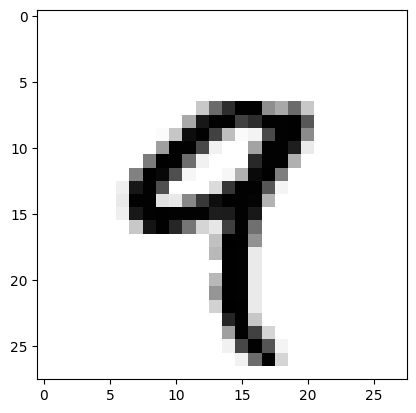

In [2]:
### Loading the MNIST dataset in Keras
#loading the training set and the test set
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#looking at the training set
print(train_images.shape)
print(len(train_labels))
print(train_labels)
print(train_images.dtype)

#looking at the test set
print(test_images.shape)
print(len(test_labels))
print(test_labels)

#displaying the fourth digit
digit = train_images[4]

plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

In [3]:
### The network architecture
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

c:\Users\lucas\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Camadas** extraem **representações** dos dados - idealmente, representações mais significativas para o problema em questão. A maior parte do aprendizado profundo consiste em encadear camadas simples que implementarão uma forma de **destilação** progressiva de dados. Um modelo de aprendizado profundo é como uma peneira para processamento de dados, feito de uma sucessão de filtros de dados - as camadas - cada vez mais refinados.

Aqui, nossa rede consiste em uma sequência de duas camadas `Dense`, que são camadas neurais densamente conectadas (também chamadas de **totalmente conectadas**). A segunda (e última) camada é uma camada **softmax** de 10 vias, o que significa que ela retornará uma matriz de 10 pontuações de probabilidade (somando 1). Cada pontuação será a probabilidade de que a imagem atual do dígito pertença a uma de nossas 10 classes de dígitos.

Para preparar a rede para o treinamento, precisamos escolher mais três coisas como parte da etapa de compilação:
- **Função de perda (loss function)**: como a rede será capaz de medir seu desempenho nos dados de treinamento e, assim, como ela será capaz de se orientar na direção certa.
- **Otimizador (optimizer)**: o mecanismo por meio do qual a rede se atualizará com base nos dados que ela vê e em sua função de perda.
- **Métricas para monitorar durante o treinamento e teste**: Aqui, nos importaremos apenas com a precisão (a fração das imagens que foram classificadas corretamente).

In [4]:
### The compilation step
network.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Antes do treinamento, pré-processaremos os dados remodelando-os na forma que a rede espera e dimensionando-os para que todos os valores estejam no intervalo `[0, 1]`. Anteriormente, nossas imagens de treinamento, por exemplo, eram armazenadas em uma matriz de dimensão `(60000, 28, 28)` do tipo `uint8` com valores no intervalo `[0, 255]`. Transformamos isso em uma matriz `float32` de dimensão `(60000, 28 * 28)` com valores entre 0 e 1.

In [5]:
# Creating a validation set
test_len = int(test_images.shape[0]/2)
test_images, val_images = test_images[:test_len], test_images[test_len:]
test_labels, val_labels = test_labels[:test_len], test_labels[test_len:]

In [6]:
### Preparing the image data

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((test_len, 28 * 28))
test_images = test_images.astype('float32') / 255
val_images = val_images.reshape((test_len, 28 * 28))
val_images = val_images.astype('float32') / 255


Também precisamos codificar categoricamente os rótulos, um passo que será explicado em momento oportuno.

In [7]:
### Preparing the labels

from keras.utils import to_categorical
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)
val_labels = to_categorical(val_labels)


Agora estamos prontos para treinar a rede, o que no Keras é feito por meio de uma chamada ao método `fit` da rede - ajustamos o modelo aos dados de treinamento.

### Calculando o número de épocas que minimiza o overfitting

In [8]:
# Adding early stopping
from keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [9]:
network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 407,050 (1.55 MB)

 Trainable params: 407,050 (1.55 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = network.fit(train_images, train_labels,
            epochs=10_000,
            batch_size=128,
            callbacks=early_stopping_callback,
            validation_data=(val_images, val_labels)
            )

Epoch 1/10000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8709 - loss: 0.4369 - val_accuracy: 0.9746 - val_loss: 0.0869
Epoch 2/10000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9636 - loss: 0.1237 - val_accuracy: 0.9828 - val_loss: 0.0594
Epoch 3/10000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9773 - loss: 0.0800 - val_accuracy: 0.9856 - val_loss: 0.0485
Epoch 4/10000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9839 - loss: 0.0570 - val_accuracy: 0.9866 - val_loss: 0.0424
Epoch 5/10000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9891 - loss: 0.0414 - val_accuracy: 0.9874 - val_loss: 0.0398
Epoch 6/10000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9925 - loss: 0.0301 - val_accuracy: 0.9878 - val_loss: 0.0388
Epoch 7/10000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9955 - loss: 0.0219 - val_accuracy: 0.9882 - val_loss: 0.0372
Epoch 8/10000
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9967 - loss: 0

In [11]:
history_dict = history.history

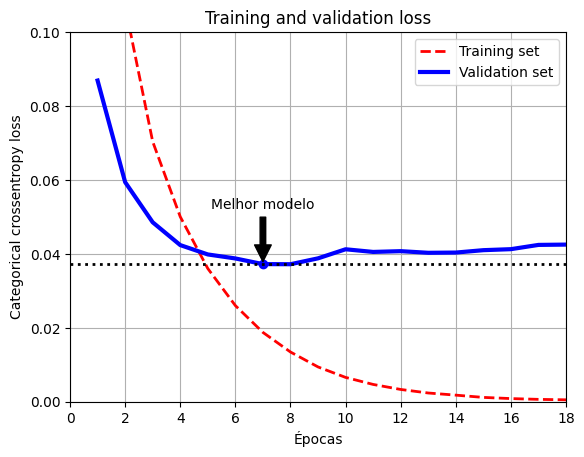

In [24]:
# Plotting the training and validation loss

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

best_epoch = np.argmin(val_loss_values)
best_valid_loss = val_loss_values[best_epoch]
n_epochs = len(loss_values)

epochs = range(1, len(loss_values) + 1)

# Plotting loss lines
plt.plot(epochs, loss_values, "r--", linewidth=2, label="Training set")
plt.plot(epochs, val_loss_values, "b-", linewidth=3, label="Validation set")
# Marking the best epoch
plt.plot(best_epoch, best_valid_loss, "bo")
plt.plot([0, n_epochs], [best_valid_loss, best_valid_loss], "k:", linewidth=2)
plt.annotate('Melhor modelo',
             xy=(best_epoch, best_valid_loss),
             xytext=(best_epoch, best_valid_loss + 0.015),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05))



plt.grid()
plt.title('Training and validation loss')
plt.xlabel('Épocas')
plt.ylabel('Categorical crossentropy loss')
plt.legend()
# for e,l in zip(epochs, val_loss_values):
#     if l < 0.10:
#         plt.text(e, l+.001, f"{l:.3f}", horizontalalignment="left")
plt.axis([0, n_epochs, 0, 0.10])
plt.savefig("./imgs/mnist_loss_x_epochs.png")
plt.show()

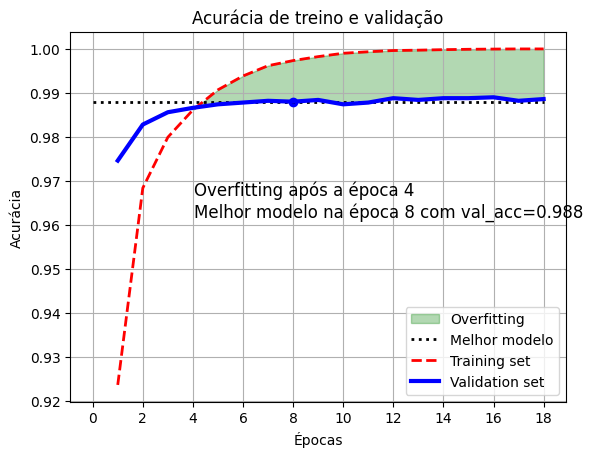

In [22]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

# Get the value epoch between training and validation
diff = np.abs(np.subtract(acc_values, val_acc_values))
overfit_epoch = np.argmin(diff)
# Color overfitting area
plt.fill_between(epochs, acc_values, val_acc_values, where=(epochs >= overfit_epoch+1), color="green", alpha=0.3, label='Overfitting')
message = f"Overfitting após a época {overfit_epoch+1}\nMelhor modelo na época {best_epoch+1} com val_acc={val_acc_values[best_epoch]:.3f}"

# Plot best epoch
plt.plot(best_epoch+1, val_acc_values[best_epoch], "bo")
plt.plot([0, n_epochs], [val_acc_values[best_epoch], val_acc_values[best_epoch]], "k:", linewidth=2, label="Melhor modelo")

plt.annotate(message, xycoords="axes fraction", xy=(0.25, 0.5), fontsize=12)
plt.plot(epochs, acc_values, "r--", linewidth=2, label="Training set")
plt.plot(epochs, val_acc_values, "b-", linewidth=3, label="Validation set")
plt.title('Acurácia de treino e validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.xticks(np.arange(0, n_epochs+1, 2))
plt.legend()
plt.grid()
plt.savefig("./imgs/mnist_acc_x_epochs.png")
plt.show()

In [15]:
best_epoch

7

Vamos agora testar o modelo no `test set`.

In [14]:
test_loss, test_acc = network.evaluate(test_images, test_labels)
print('test_acc:', test_acc)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9762 - loss: 0.0796
test_acc: 0.9721999764442444


## Conclusão

Como é possível observar no gráfico acima, o modelo apresentou um overfitting no conjunto de dados de treino, ou seja, a partir da 4ª época, a acurácia no conjunto de treino continuou a aumentar, enquanto a acurácia no conjunto de validação não acompanhou o aumento. Isso é um sinal de que o modelo está memorizando os dados de treino e não generalizando bem para novos dados.

Um ponto a ser observado é que por mais que o modelo começou a apresentar overfitting a partir da 4ª época, a acurácia no conjunto de validação continuou a aumentar até a 8ª época, o que é um sinal de que o modelo ainda não está completamente saturado e que ainda continua a aprender atributos relevantes quando ele começa a apresentar o overfitting, por mais que o *signal to noise ratio* esteja diminuindo.

Por fim, quando avaliamos o modelo no conjunto de teste, a acurácia foi de 97.2% (contra 98.6% no conjunto de validação), o que parece indicar de que o modelo generalizou bem para novos dados, porém que também apresentou overfitting para os dados de validação.

#### Resumo

- O modelo apresentou overfitting no conjunto de dados de treino a partir da 4ª época
- A acurácia no conjunto de validação continuou a aumentar até a 8ª época, o que indica que o modelo ainda que em overfitting, ainda está aprendendo atributos relevantes até a 8ª época.
- A acurácia no conjunto de teste foi relativamente menor que a acurácia no conjunto de validação, o que indica que o modelo generalizou bem para novos dados, porém que também apresentou overfitting para os dados de validação.

#### Métricas
| Conjunto de dados | Acurácia |
|--------------------|----------|
| Treino             | 99.6%    |
| Validação          | 98.8%    |
| Teste              | 97.2%    |